In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import pickle
import scipy.signal
import glob
import cv2
from skimage.exposure import rescale_intensity
import argparse
from sklearn.cluster import KMeans
from itertools import groupby
from skimage import color, data, restoration
import h5py
import random
from tqdm import tqdm
import os
import time

In [2]:
fs = 500000
spec_params={
'nperseg': 512, # default 1024
'noverlap': 256, # default: nperseg / 4
'fs': fs, # raw signal sample rate is 4MHz
'window': 'hamm',
'scaling': 'density', # {'density', 'spectrum'}
'detrend': 'linear', # {'linear', 'constant', False}
'eps': 1e-11}

# returns spectrogram
def specgr (fname,ecen,spec_params,cut_shot):
    ece_data = pickle.load(open(fname,'rb'))
    ece_num = '\\tecef%.2i' % (ecen)
    sig_in = ece_data[ece_num][:np.int_(cut_shot*spec_params['fs'])]
    f, t, Sxx = scipy.signal.spectrogram(sig_in, nperseg=spec_params['nperseg'], noverlap=spec_params['noverlap'],fs=spec_params['fs'], window=spec_params['window'],scaling=spec_params['scaling'], detrend=spec_params['detrend'])
    Sxx = np.log(Sxx + spec_params['eps'])
    Sxx=(Sxx-np.min(Sxx))/(np.max(Sxx)-np.min(Sxx))
    Sxx = Sxx[:-1,:];f=f[:-1]
    return Sxx,f,t

# different denoising techniques
def norm(data):
    mn = data.mean()
    std = data.std()
    return((data-mn)/std)

def rescale(data):
    return (data-data.min())/(data.max()-data.min())

def quantfilt(src,thr=0.9):
    filt = np.quantile(src,thr,axis=0)
    out = np.where(src<filt,0,src)
    return out

def gaussblr(src,filt=(31, 3)):
    src = (rescale(src)*255).astype('uint8')
    out = cv2.GaussianBlur(src,filt,0)
    return rescale(out)

def bilateral(src):
    src = (rescale(src)*255).astype('uint8')
    out = cv2.bilateralFilter(src, 15, 75, 75)
    return rescale(out)

def meansub(src):
    mn = np.mean(src,axis=1)[:,np.newaxis]
    out = np.absolute(src - mn)
    return rescale(out)

def morph(src):
    src = (rescale(src)*255).astype('uint8')
    
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))
    mask = cv2.morphologyEx(src, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
        
    return rescale(mask)


In [3]:
# load data
data_path = "/scratch/gpfs/aonelson/ml_database/ECE_data/"
flist = glob.glob(data_path+"*.pkl")
result_path = "frames/"

spectrograms = []
final = []
thr = 0.9

random_sample = random.sample(flist, 100)

for fname in tqdm(random_sample):
    shotn = fname[fname.rfind('_')+1:fname.rfind('.')]
    Sxx = []

    for chn in range(20):
        try:
            s,f,t = specgr(fname,chn+1,spec_params,2)
            Sxx.append(s)
        except pickle.UnpicklingError as e:
            continue
        except Exception as e:
            print(traceback.format_exc(e))
            continue
    
    Sxx = np.dstack(Sxx)
    spectrograms.append(Sxx)
    
    out_quant= quantfilt(Sxx,thr)
    out_gauss=np.empty(Sxx.shape)
    out_mean=np.empty(Sxx.shape)
    out_morph = np.empty(Sxx.shape)
    out_final = np.empty(Sxx.shape)

    for i in range(20):
        out_gauss[:,:,i] =  gaussblr(out_quant[:,:,i],(31, 3))
        out_mean[:,:,i] = meansub(out_gauss[:,:,i])    
        out_morph[:,:,i] = morph(out_mean[:,:,i])
        out_final[:,:,i] = meansub(out_morph[:,:,i])
    
    final.append(out_final)

100%|██████████| 100/100 [15:38<00:00,  9.39s/it]


In [29]:
#split into 60,25,15

Sxx_train = spectrograms[:60]
final_train = final[:60]

Sxx_tune = spectrograms[60:85]
final_tune = final[60:85]

Sxx_test = spectrograms[85:]
final_test = final[85:]

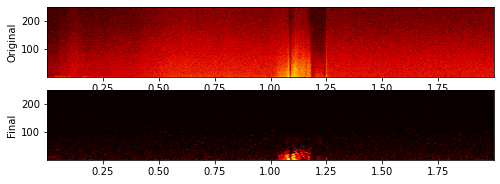

In [28]:
#plots first spectrogram in training data
chn = 1

fig = plt.figure(figsize=(8,12))
grd = gridspec.GridSpec(ncols=1, nrows=8, figure=fig)
ax=[None] * 2

ax[0] = fig.add_subplot(grd[0])
ax[0].pcolormesh(t,(f/1000)+1,Sxx_train[0][:,:,chn],cmap='hot',shading='gouraud')
_=plt.ylabel('Original')

ax[1] = fig.add_subplot(grd[1])
ax[1].pcolormesh(t,(f/1000)+1,final_train[0][:,:,chn],cmap='hot',shading='gouraud')
_=plt.ylabel('Final')